In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
import joblib
import json
from datetime import datetime
import os

In [3]:
df = pd.read_csv("Walmart.csv")

In [4]:
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

In [5]:
print(f"  Shape: {df.shape}")

  Shape: (6435, 8)


In [6]:
display(df.head())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [8]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
print(f"Date converted and data sorted")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Duration: {(df['Date'].max() - df['Date'].min()).days} days")

Date converted and data sorted
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Duration: 994 days


In [9]:
display(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [10]:
print("\nDuplicate rows: ",df.duplicated().sum())


Duplicate rows:  0


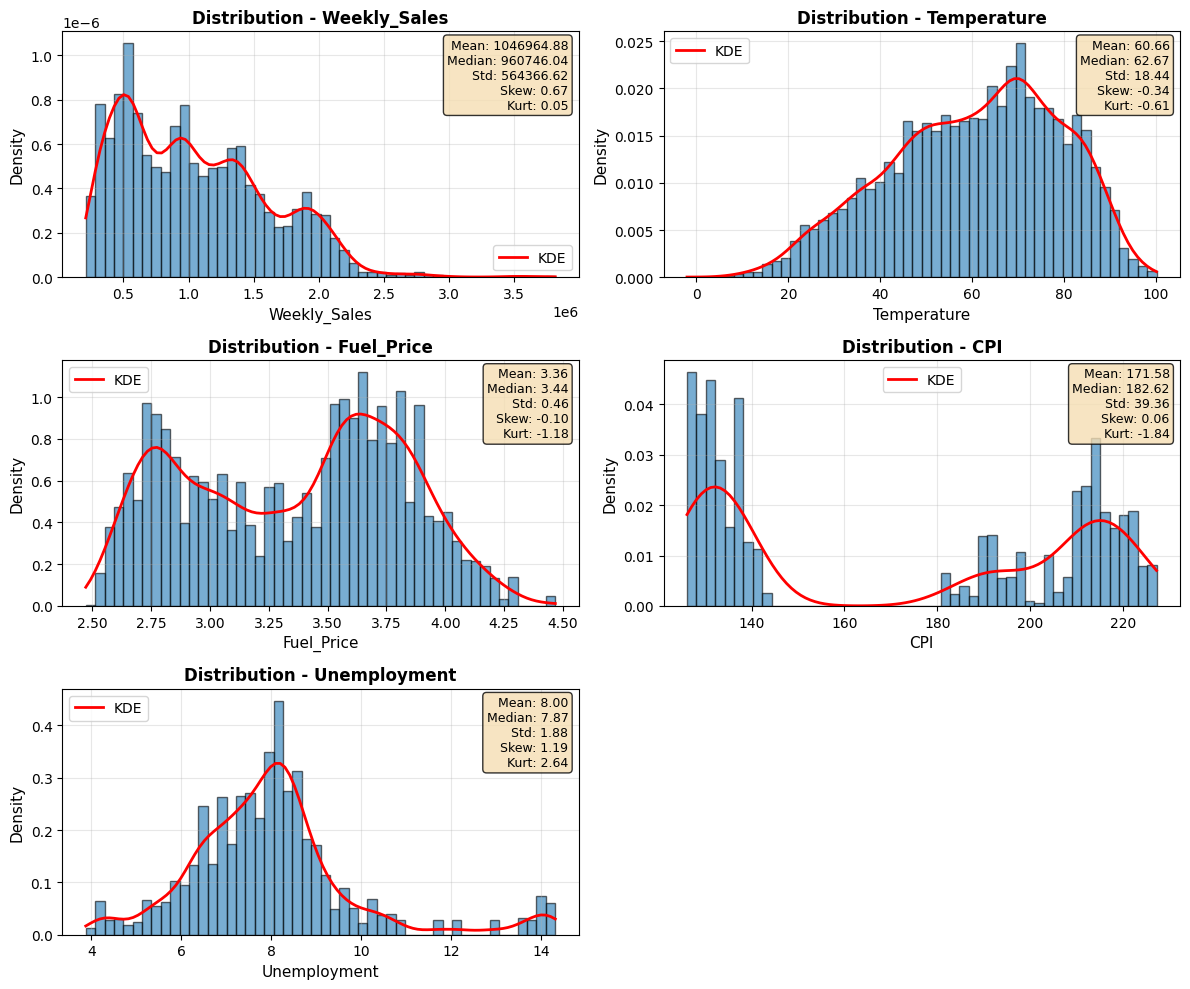

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data = df[col].dropna()

    axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.6, density=True)

    from scipy.stats import gaussian_kde
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].set_title(f'Distribution - {col}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

    stats_text = f'Mean: {data.mean():.2f}\nMedian: {data.median():.2f}\nStd: {data.std():.2f}\nSkew: {data.skew():.2f}\nKurt: {data.kurtosis():.2f}'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                   fontsize=9)

axes[-1].axis('off')
plt.tight_layout()

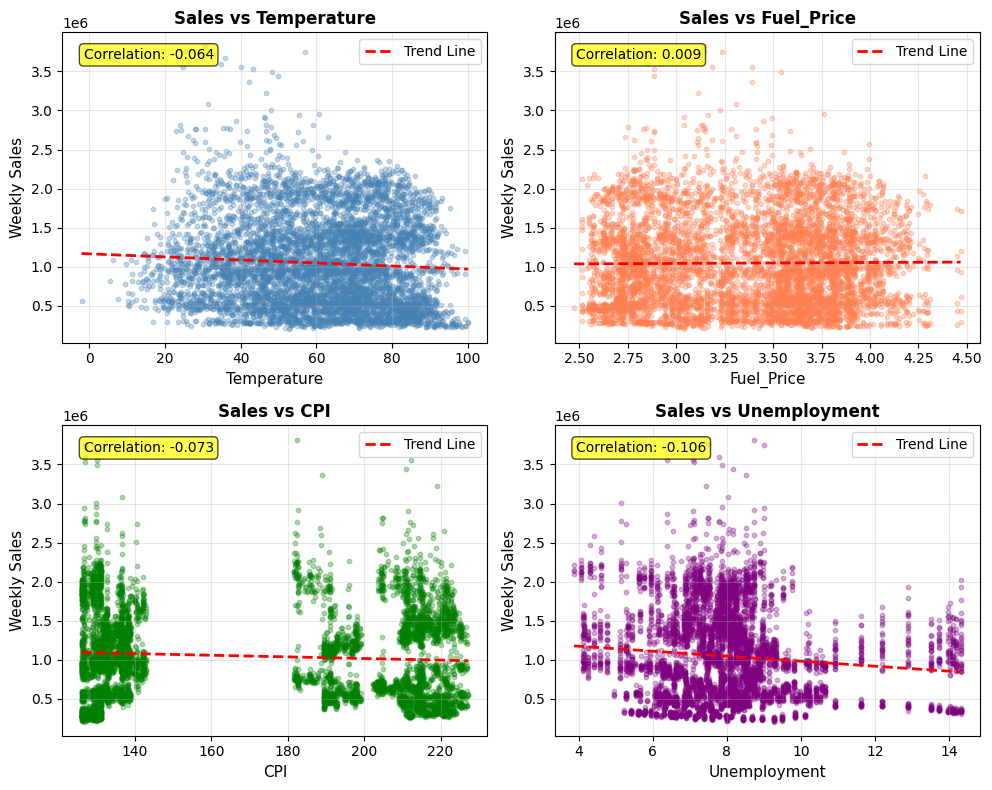

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
colors = ['steelblue', 'coral', 'green', 'purple']

for idx, (feat, color) in enumerate(zip(features, colors)):
    axes[idx].scatter(df[feat], df['Weekly_Sales'], alpha=0.3, s=10, color=color)

    z = np.polyfit(df[feat], df['Weekly_Sales'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[feat].min(), df[feat].max(), 100)
    axes[idx].plot(x_line, p(x_line), "r", linewidth=2, label='Trend Line')

    corr = df[feat].corr(df['Weekly_Sales'])

    axes[idx].set_xlabel(feat, fontsize=11)
    axes[idx].set_ylabel('Weekly Sales', fontsize=11)
    axes[idx].set_title(f'Sales vs {feat}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[idx].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()

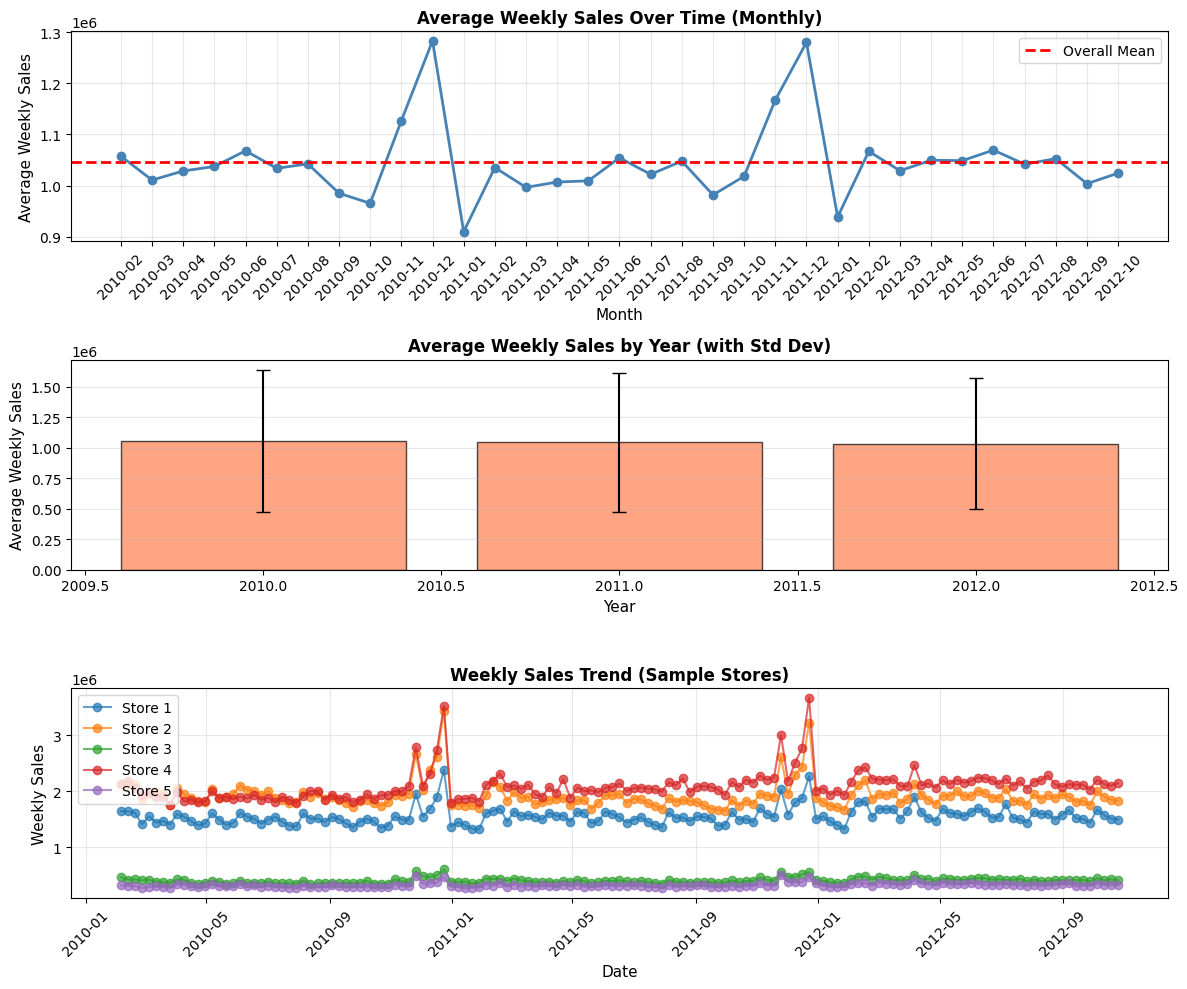

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Weekly_Sales'].mean()
axes[0].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linewidth=2, color='steelblue')
axes[0].set_xlabel('Month', fontsize=11)
axes[0].set_ylabel('Average Weekly Sales', fontsize=11)
axes[0].set_title('Average Weekly Sales Over Time (Monthly)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=monthly_sales.mean(), color='r', linestyle='', linewidth=2, label='Overall Mean')
axes[0].legend()

yearly_sales = df.groupby(df['Date'].dt.year)['Weekly_Sales'].agg(['mean', 'std'])
axes[1].bar(yearly_sales.index, yearly_sales['mean'], alpha=0.7, edgecolor='black',
            yerr=yearly_sales['std'], capsize=5, color='coral')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Average Weekly Sales', fontsize=11)
axes[1].set_title('Average Weekly Sales by Year (with Std Dev)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

sample_stores = df['Store'].unique()[:5]
for store in sample_stores:
    store_data = df[df['Store'] == store].groupby('Date')['Weekly_Sales'].mean()
    axes[2].plot(store_data.index, store_data.values, marker='o', label=f'Store {store}', alpha=0.7, linewidth=1.5)

axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Weekly Sales', fontsize=11)
axes[2].set_title('Weekly Sales Trend (Sample Stores)', fontsize=12, fontweight='bold')
axes[2].legend(loc='best')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

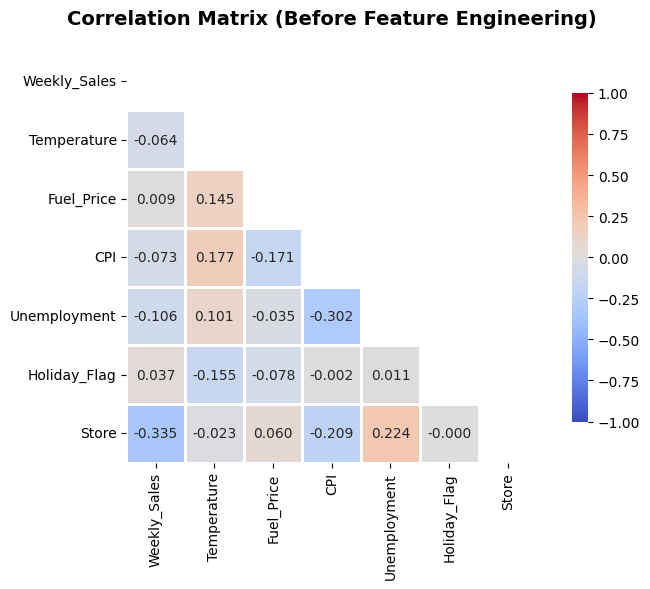

In [14]:
numeric_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag', 'Store']
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix (Before Feature Engineering)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

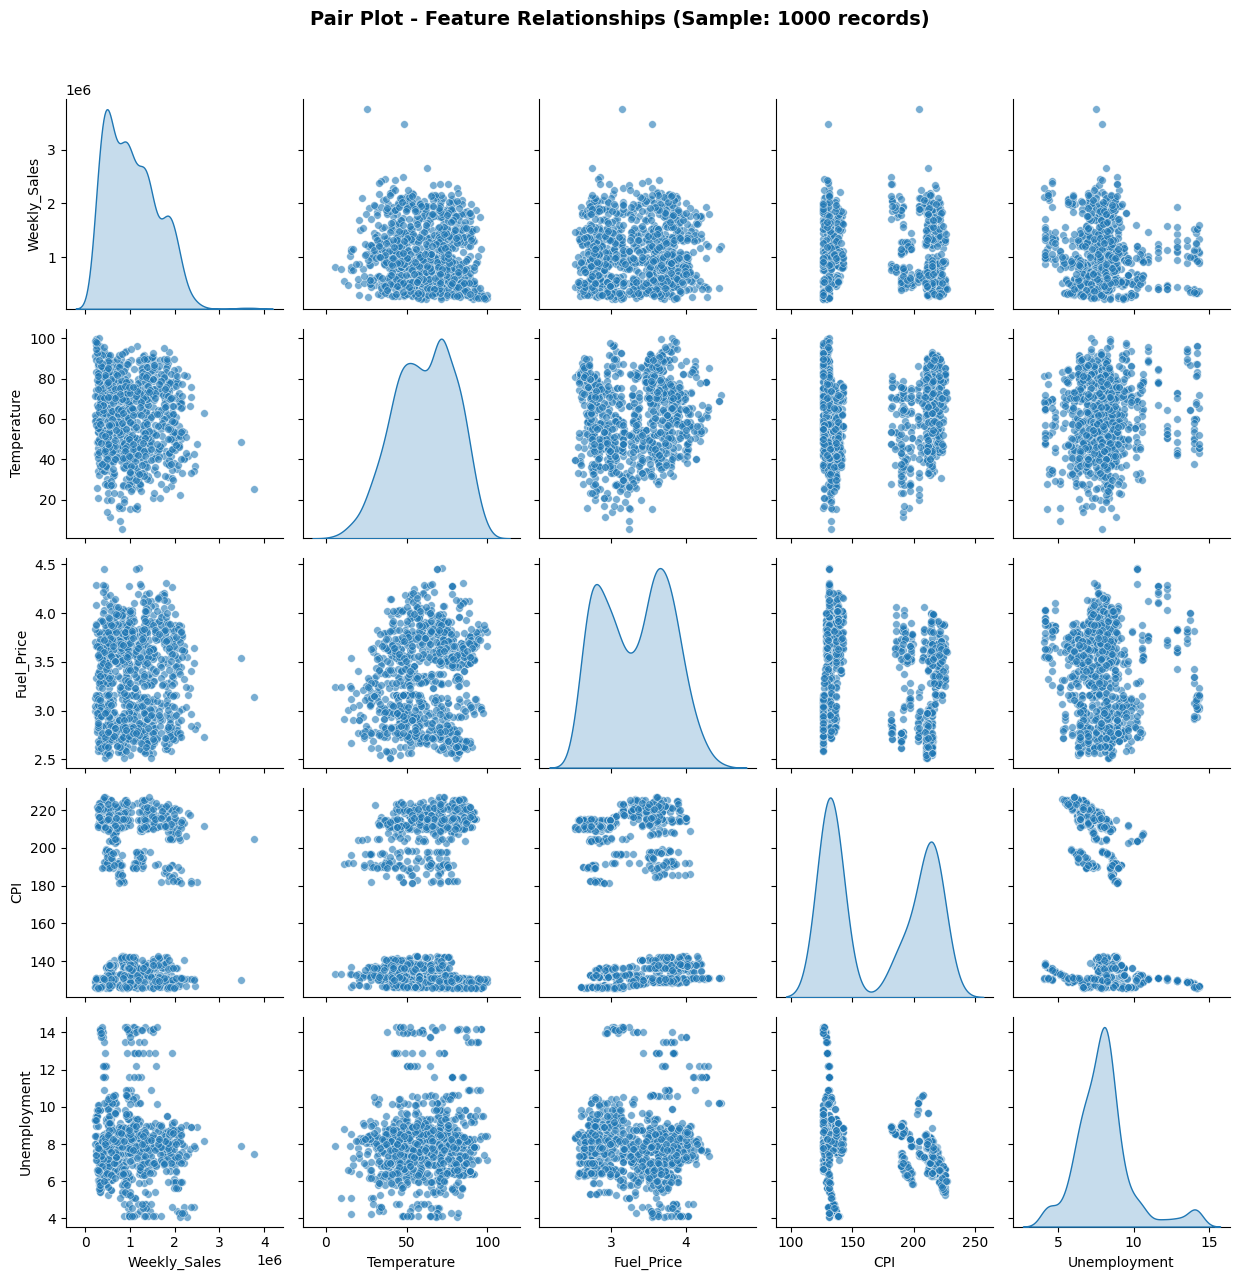

In [15]:
sample_df = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].sample(n=min(1000, len(df)), random_state=42)
pair_plot = sns.pairplot(sample_df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
pair_plot.fig.suptitle('Pair Plot - Feature Relationships (Sample: 1000 records)', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()

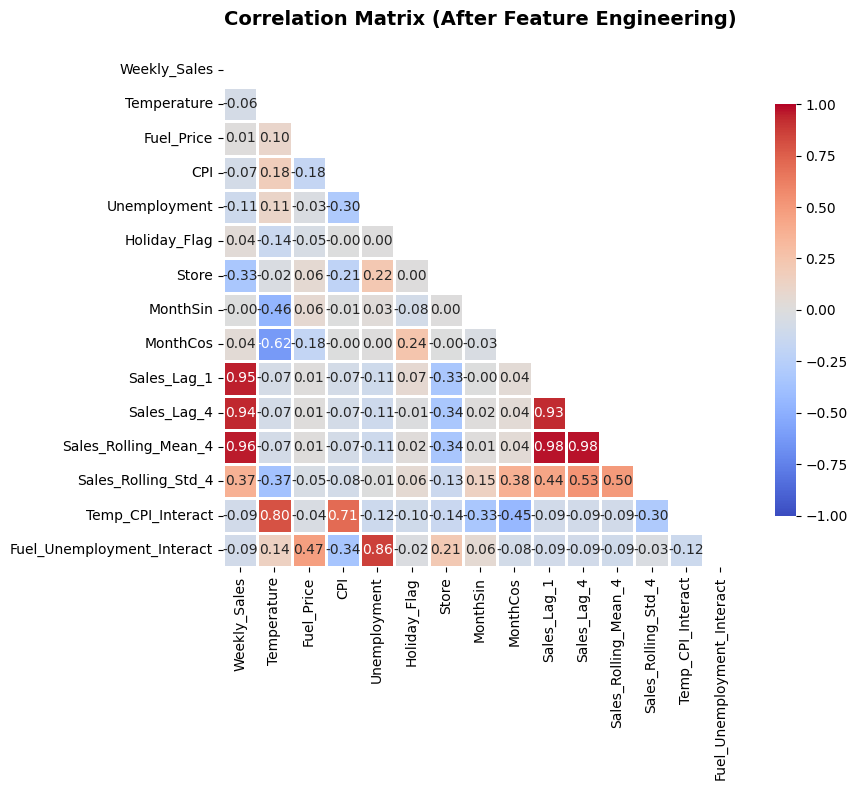

In [16]:
df = df.copy()
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['Month'] = df['Date'].dt.month
df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Sales_Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)
df['Sales_Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).mean()
df['Sales_Rolling_Std_4'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).std()

df['Temp_CPI_Interact'] = df['Temperature'] * df['CPI']
df['Fuel_Unemployment_Interact'] = df['Fuel_Price'] * df['Unemployment']

df = df.dropna()

numeric_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                    'Holiday_Flag', 'Store', 'MonthSin', 'MonthCos',
                    'Sales_Lag_1', 'Sales_Lag_4', 'Sales_Rolling_Mean_4', 'Sales_Rolling_Std_4',
                    'Temp_CPI_Interact', 'Fuel_Unemployment_Interact']
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix (After Feature Engineering)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

In [17]:
def create_features(data):
    df = data.copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsMonthStart'] = (df['Date'].dt.day <= 7).astype(int)
    df['IsMonthEnd'] = (df['Date'].dt.day >= 23).astype(int)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

    for store in df['Store'].unique():
        idx = df['Store'] == store
        sales = df.loc[idx, 'Weekly_Sales']
        for lag in [1, 2, 4, 8, 12]:
            df.loc[idx, f'Sales_Lag_{lag}'] = sales.shift(lag)
        for w in [4, 8, 12]:
            df.loc[idx, f'Sales_RollMean_{w}'] = sales.rolling(w, min_periods=1).mean()
            df.loc[idx, f'Sales_RollStd_{w}'] = sales.rolling(w, min_periods=1).std().fillna(0)

    for col in df.columns:
        if 'Lag' in col or 'Roll' in col:
            df[col] = df.groupby('Store')[col].transform(lambda x: x.fillna(x.mean()))

    df['Holiday_Unemp'] = df['Holiday_Flag'] * df['Unemployment']
    df['Holiday_Temp'] = df['Holiday_Flag'] * df['Temperature']
    df['CPI_Unemp'] = df['CPI'] * df['Unemployment']
    df['Week_Counter'] = df.groupby('Store').cumcount() + 1
    return df

df_full = create_features(df)

In [18]:
percentiles = np.percentile(df_full['Weekly_Sales'], [33, 67])
df_full['Sales_Category'] = np.where(
    df_full['Weekly_Sales'] < percentiles[0], 0,
    np.where(df_full['Weekly_Sales'] < percentiles[1], 1, 2)
)

In [19]:
split_date = df_full['Date'].quantile(0.8)
train_idx = df_full['Date'] < split_date
X = df_full[[
    'Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag',
    'Year', 'Month', 'Week', 'Quarter', 'DayOfYear', 'IsMonthStart', 'IsMonthEnd',
    'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos',
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_12',
    'Sales_RollMean_4', 'Sales_RollMean_8', 'Sales_RollMean_12',
    'Sales_RollStd_4', 'Sales_RollStd_8', 'Sales_RollStd_12',
    'Holiday_Unemp', 'Holiday_Temp', 'CPI_Unemp', 'Week_Counter'
]]
y = df_full['Sales_Category']

X_train, X_val = X[train_idx], X[~train_idx]
y_train, y_val = y[train_idx], y[~train_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [20]:
RANDOM_STATE = 42
models = {
    'Decision_Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random_Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'Logistic_Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Ridge_Classifier': RidgeClassifier(random_state=RANDOM_STATE),
    'Naive_Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'SVM_RBF': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True),
    'Neural_Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=RANDOM_STATE, max_iter=500),
}
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='mlogloss')
except Exception: pass
try:
    import lightgbm as lgb
    models['LightGBM'] = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
except Exception: pass

In [21]:
results = []
for name, model in models.items():
    print(f"Training {name} …")
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_val_scaled)
    f1 = f1_score(y_val, pred, average='weighted')
    results.append({'name': name, 'model': model, 'f1': f1})

results = sorted(results, key=lambda x: x['f1'], reverse=True)
top_n = 3
top3 = results[:top_n]
top3_models = [r['model'] for r in top3]
top3_names  = [r['name']  for r in top3]
top3_f1     = [r['f1']    for r in top3]

Training Decision_Tree …
Training Random_Forest …
Training Gradient_Boosting …
Training AdaBoost …
Training Logistic_Regression …
Training Ridge_Classifier …
Training Naive_Bayes …
Training LDA …
Training KNN …
Training SVM_RBF …
Training Neural_Network …
Training XGBoost …
Training LightGBM …


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

joblib.dump(top3_models, f'{MODELS_DIR}/top3_models.pkl')
joblib.dump(top3_names,  f'{MODELS_DIR}/top3_names.pkl')
joblib.dump(top3_f1,     f'{MODELS_DIR}/top3_f1.pkl')
joblib.dump(scaler,      f'{MODELS_DIR}/scaler.pkl')
joblib.dump(list(X.columns), f'{MODELS_DIR}/feature_names.pkl')
joblib.dump(percentiles, f'{MODELS_DIR}/percentiles.pkl')
joblib.dump(df_full,     f'{MODELS_DIR}/training_data_full.pkl')

['models/training_data_full.pkl']

In [23]:
leaderboard = [{'rank': i+1, 'name': r['name'], 'f1': round(r['f1'], 4)} for i, r in enumerate(results)]
metrics = {
    'training_date': datetime.now().isoformat(),
    'total_records': len(df_full),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'percentiles': percentiles.tolist(),
    'feature_count': len(X.columns),
    'top3_models': top3_names,
    'top3_f1': top3_f1,
    'leaderboard': leaderboard
}
with open(f'{MODELS_DIR}/model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\nTOP-3")
for i, (n, f) in enumerate(zip(top3_names, top3_f1), 1):
    print(f"{i}. {n}: F1 = {f:.4f}")


TOP-3
1. XGBoost: F1 = 0.9802
2. LightGBM: F1 = 0.9786
3. Gradient_Boosting: F1 = 0.9730


In [24]:
feature_dict = {}

# basic columns 
for col in ['Store','Temperature','Fuel_Price','CPI','Unemployment','Holiday_Flag']:
    feature_dict[col] = {
        "category": "Raw",
        "why": f"Directly provided in the dataset – {col.lower()} impacts sales.",
        "example": f"df['{col}']"
    }

# date parts 
for col in ['Year','Month','Week','Quarter','DayOfYear','IsMonthStart','IsMonthEnd']:
    feature_dict[col] = {
        "category": "Date",
        "why": "Temporal patterns (seasonality, year-over-year growth).",
        "example": f"df['Date'].dt.{col.lower()}"
    }

# cyclical 
for base, sin, cos in [('Month','Month_sin','Month_cos'), ('Week','Week_sin','Week_cos')]:
    feature_dict[sin] = {
        "category": "Cyclical",
        "why": f"Sine encoding of {base.lower()} – removes ordinal bias.",
        "example": f"np.sin(2*np.pi*df['{base}']/ {12 if base=='Month' else 52})",
        "plot_type": "cyclical",
        "plot_data": {"period": 12 if base=='Month' else 52}
    }
    feature_dict[cos] = {
        "category": "Cyclical",
        "why": f"Cosine encoding of {base.lower()}.",
        "example": f"np.cos(2*np.pi*df['{base}']/ {12 if base=='Month' else 52})",
        "plot_type": "cyclical",
        "plot_data": {"period": 12 if base=='Month' else 52}
    }

# lags 
for lag in [1,2,4,8,12]:
    col = f'Sales_Lag_{lag}'
    feature_dict[col] = {
        "category": "Lag",
        "why": f"Sales {lag} week(s) ago – captures autocorrelation.",
        "example": f"df.groupby('Store')['Weekly_Sales'].shift({lag})",
        "plot_type": "scatter_lag",
        "plot_data": {"lag": lag}
    }

# rolling 
for w in [4,8,12]:
    for stat in ['Mean','Std']:
        col = f'Sales_Roll{stat}_{w}'
        feature_dict[col] = {
            "category": "Rolling",
            "why": f"{stat.lower()} of sales over last {w} weeks – trend / volatility.",
            "example": f"df.groupby('Store')['Weekly_Sales'].rolling({w}).{stat.lower()}()",
            "plot_type": "rolling_demo" if stat=='Mean' else "none",
            "plot_data": {"window": w}
        }

# interactions 
for col in ['Holiday_Unemp','Holiday_Temp','CPI_Unemp']:
    feature_dict[col] = {
        "category": "Interaction",
        "why": "Multiplicative effect between two drivers.",
        "example": f"df['{col.split('_')[0]}'] * df['{col.split('_',1)[1]}']"
    }

# week counter 
feature_dict['Week_Counter'] = {
    "category": "Meta",
    "why": "How many weeks of history the store has – proxy for maturity.",
    "example": "df.groupby('Store').cumcount() + 1"
}

# holiday boost 
feature_dict['Holiday_Flag']['plot_type'] = "bar_boost"
feature_dict['Holiday_Flag']['plot_data'] = {"feature": "Holiday_Flag"}

with open('feature_dict.json', 'w') as f:
    json.dump(feature_dict, f, indent=2)